In [1]:
#IPR for horizontal undersaturated oil well with distributed inflow and
#pressure drop along the lateral using Ben J. Dikken concept
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import numpy as np

In [2]:
def NRe(den,vis,ID,v): #Reynolds number
    return den*ID*v/vis

def ffactor(Nre,roughness,ID):
    #Nre = dimensionless flow velocity, Reynolds number (Nre=rho*D*u/µ) [(dim.less)]
    #roughness = pipe roughness [m]
    #ID = internal pipe diameter [m]
    if Nre ==0:
        f= 0
    elif Nre < 2300: #laminar flow, Blasius
        f= 64 / Nre
    else:  #turbulent flow, Haaland (1983)
        f= (1 / (-1.8 * np.log10((6.9 / Nre) + (roughness / (3.7 * ID))**1.11)))**2
    return f

def dpwdx(qo_sc,p,ID,roughness,PVTMatrix):
    qo_sc=qo_sc/(3600*24)
    Bo=np.interp(p, PVTMatrix[:,0], PVTMatrix[:,2])
    qo=qo_sc*Bo
    v=qo/((np.pi*0.25*(ID**2)))
    den=np.interp(p, PVTMatrix[:,0], PVTMatrix[:,4])
    vis=np.interp(p, PVTMatrix[:,0], PVTMatrix[:,3])*1e-3
    Re=NRe(den,vis,ID,v)
    ff=ffactor(Re,roughness,ID)
    output=-ff*den*(v**2)/(2*ID*1e5)
    return output

def dqo_scdx(j,pR,pw):
    output=j*(pR-pw)
    return output

def fun(u,x,ID,roughness,PVTMatrix,j,pR):
    pw=u[0]
    qo_sc=u[1]
    eq1=dpwdx(qo_sc,pw,ID,roughness,PVTMatrix)
    eq2=dqo_scdx(j,pR,pw)
    return (eq1,eq2)

In [3]:
#INPUT
Lw=1000   #m, wellbore length
D=0.07    #Wellbore diameter, m
J=64      #Sm3/d/bar productivity index of horizontal well
rough=1e-5  #m, pipe roughness
pR=300     #bara, reservoir pressure
PVTProperties=np.loadtxt("PVT_Properties.txt",skiprows=1)
j=J/(Lw)  #specific productivity index by unit length Sm3/d/bara/m

In [4]:
#initial conditions
p_toe=200  #bara, pressure at the toe, value assumed
q_toe=0  #Sm3/d, rate at the toe, value assumed
y0=[p_toe,q_toe]  #Initial conditions to solve the system of ODEs
#solving
x=np.linspace(0,Lw,100)
results=odeint(fun,y0,x,args=(D,rough,PVTProperties,j,pR))
pw=results[:,0]
qw=results[:,1]

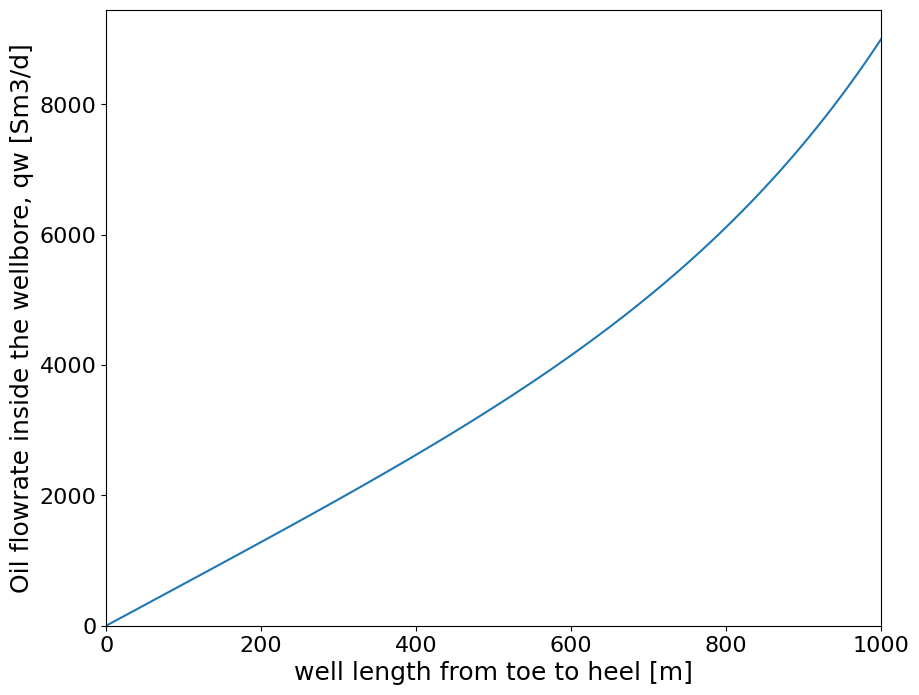

In [5]:
plt.figure(figsize=(10,8))
plt.plot(x,qw,'-')
plt.xlabel('well length from toe to heel [m]',fontsize=18)
plt.ylabel('Oil flowrate inside the wellbore, qw [Sm3/d]',fontsize=18)
plt.xlim(0,Lw)
plt.ylim(0)
plt.xticks(fontsize=16 )
plt.yticks(fontsize=16 )
plt.show()

In [6]:
print('The total oil rate produced by the well is: ', qw.max(),' Sm3/d')

The total oil rate produced by the well is:  9001.787719102043  Sm3/d


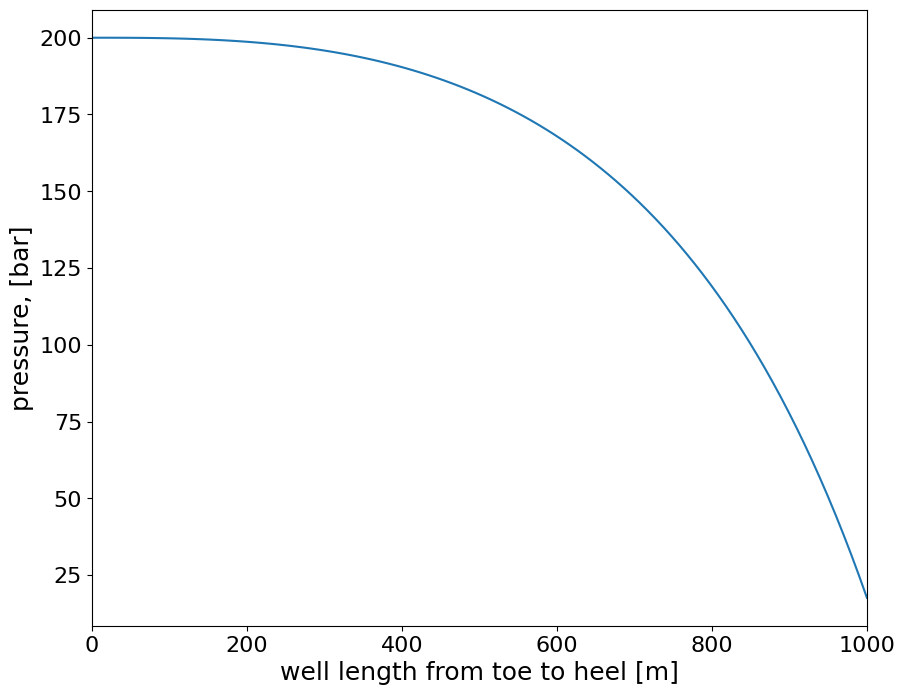

In [7]:
plt.figure(figsize=(10,8))
plt.plot(x,pw,'-')
plt.xlabel('well length from toe to heel [m]',fontsize=18)
plt.ylabel('pressure, [bar]',fontsize=18)
plt.xlim(0,Lw)
plt.xticks(fontsize=16 )
plt.yticks(fontsize=16 )
plt.show()

In [8]:
print('The pressure at the heel is: ', pw.min(),' bara')

The pressure at the heel is:  17.612913791597983  bara


In [9]:
#creating IPR
ptoe_min=100
ptoes=np.linspace(pR,ptoe_min,10)
qosc_v=[]
pwf=[]
for ptoes_i in ptoes:
    y0=[ptoes_i,0]
    #solving"
    results=odeint(fun,y0,x,args=(D,rough,PVTProperties,j,pR))
    pw=results[:,0]
    qw=results[:,1]
    qosc_v=np.append(qosc_v,qw.max())
    pwf=np.append(pwf,pw.min())

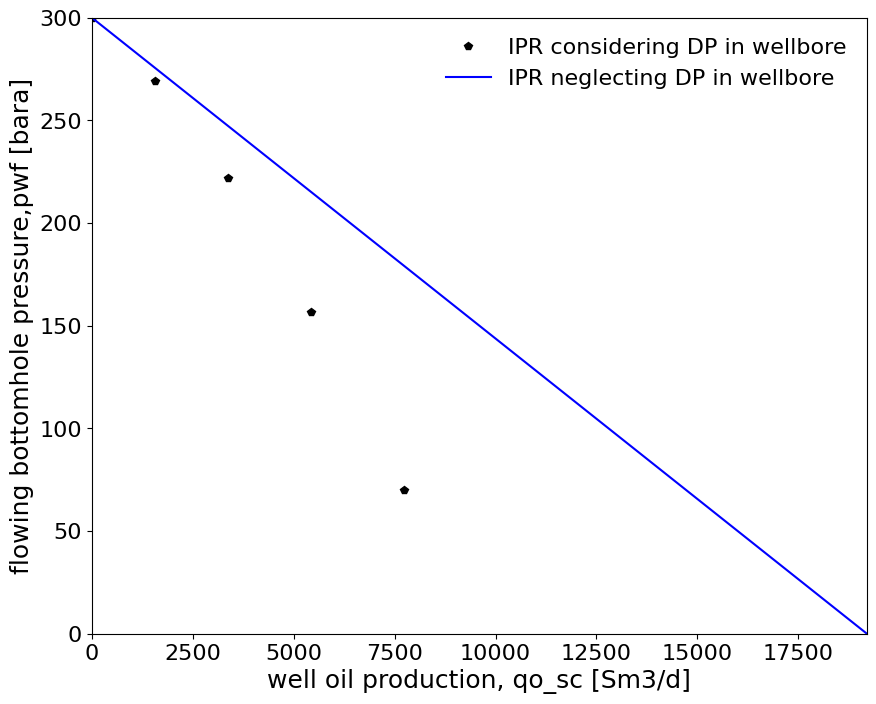

In [10]:
plt.figure(figsize=(10,8))
plt.plot(qosc_v,pwf,'p',color="black",label='IPR considering DP in wellbore')
pwf_id=np.linspace(pR,0,10)
qo_sc=J*(pR-pwf_id)
plt.plot(qo_sc,pwf_id,'-',color='blue',label='IPR neglecting DP in wellbore')
plt.xlabel('well oil production, qo_sc [Sm3/d]',fontsize=18)
plt.ylabel('flowing bottomhole pressure,pwf [bara]',fontsize=18)
plt.xlim(0,qo_sc.max())
plt.ylim(0,pR)
plt.xticks(fontsize=16 )
plt.yticks(fontsize=16 )
plt.legend(fontsize=16,frameon=False)
plt.show()